In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim

## Calibrate box, wall and sheath regions for simulation

The goal is to 
- create an adequate simulation box that contains the whole region of interest
- create a wall region such that fieldlines intersect the wall as little as possible and structures can be dampened away
- create a sheath region with distinct in- and outflow

What to look for
- sheath in and outflow should not be connected
- wall transition region should be entirely in the box (no intersections with the boundary)


In [2]:
# Define a plotting routine
def plot( f):
    ncin = Dataset( f, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    grid_ratio = (pp["grid"]["scaleZ"][1]+pp["grid"]["scaleZ"][0])/(
        pp["grid"]["scaleR"][1]+pp["grid"]["scaleR"][0])
    print("Z:R =", grid_ratio)
    p = pp["magnetic_field"]["params"]
    equi = p["equilibrium"]
    desc = p["description"]
    
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc = np.kron( np.ones(np.shape(y)),x).reshape( (np.size(y), np.size(x)))
    yc = np.kron( y, np.ones(np.shape(x))).reshape( (np.size(y), np.size(x)))
    lvls=pp["boundary"]["wall"]["boundary"]
    lvls.append(1)
    lvls=sorted(lvls)
    print( "Wall levels = ", lvls)

    frows = 2
    fcols = 2
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*8,frows*10),dpi= 80, facecolor='w', edgecolor='k')
    #im = ax[0][0].pcolormesh(xc,yc,ncin["Psip"][:,:], shading='gouraud', cmap='seismic' )

    #https://matplotlib.org/stable/tutorials/colors/colormaps.html
    rr = 0
    cc = 0   
    #im = ax[0][0].contourf(xc,yc,ncin["Psip2d"][:,:],cmap="twilight_r") 
    im = ax[rr][cc].pcolormesh(xc,yc,ncin["Rho_p"][:,:],cmap="gist_ncar", shading ="gouraud")
    fig.colorbar(im, ax=ax[rr][cc])
    im = ax[rr][cc].contour( xc, yc, ncin["Rho_p"][:,:], levels=lvls, linewidths=2,colors='k')

    ax[rr][cc].axis("scaled")
    start, end = ax[rr][cc].get_xlim()
#     ax[rr][cc].xaxis.set_ticks(np.arange(start, end, 20))
    ax[rr][cc].xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[rr][cc].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[rr][cc].xaxis.grid(which="both")
    ax[rr][cc].yaxis.grid(which="both")    
    ax[rr][cc].set_title( r"$\rho_p$")
    ax[rr][cc].set_xlabel( "R [mm]")
    ax[rr][cc].set_ylabel( "Z [mm]")
    
    rr = 0
    cc = 1    
    plot = ncin["MagneticTransition"][:,:]
    plot = np.ma.masked_array( plot, plot==0)
    im = ax[rr][cc].pcolormesh(xc, yc, plot,
                          cmap="ocean_r", shading="gouraud") 
    fig.colorbar(im, ax=ax[rr][cc])
    im = ax[rr][cc].contour( xc, yc, ncin["Rho_p"][:,:], levels=lvls, linewidths=1,colors='k')
    plot = ncin["SheathDotDirection"][:,:]
    plot = np.ma.masked_array( plot, plot==0)
    im = ax[rr][cc].pcolormesh(xc, yc, plot,
                     vmin=-1, vmax=1, cmap="bwr", shading="gouraud") 

    ax[rr][cc].axis("scaled")

#     ax[rr][cc].xaxis.grid(which="both")
#     ax[rr][cc].yaxis.grid(which="both")  
#     ax[rr][cc].xaxis.set_minor_locator(tck.AutoMinorLocator())
#     ax[rr][cc].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[rr][cc].set_title( "Magnetic Transition and Sheath")
    ax[rr][cc].set_xlabel( "R [mm]")
    ax[rr][cc].set_ylabel( "Z [mm]") 
      
    rr = 1
    cc = 0  
    name="Source"
    im = ax[rr][cc].pcolormesh(xc, yc, ncin[name][:,:],
                          cmap="ocean_r", shading="gouraud") 
    fig.colorbar(im, ax=ax[rr][cc])
    im = ax[rr][cc].contour( xc, yc, ncin["Rho_p"][:,:], levels=lvls, linewidths=2,colors='k')
    ax[rr][cc].axis("scaled")
    ax[rr][cc].set_title( name)
    ax[rr][cc].set_xlabel( "R [mm]")
    ax[rr][cc].set_ylabel( "Z [mm]")   
    rr = 1
    cc = 1
    name="neinit"
    im = ax[rr][cc].pcolormesh(xc, yc, ncin[name][:,:],
                          cmap="inferno_r", shading="gouraud") 
    fig.colorbar(im, ax=ax[rr][cc])
    im = ax[rr][cc].contour( xc, yc, ncin["Rho_p"][:,:], levels=lvls, linewidths=2,colors='k')
    ax[rr][cc].axis("scaled")
    ax[rr][cc].set_title( name)
    ax[rr][cc].set_xlabel( "R [mm]")
    ax[rr][cc].set_ylabel( "Z [mm]")
                                                  
    print(equi, desc)
    if ( equi == "solovev" or equi == "polynomial") :
        print( "triangularity=%.1f" % p["triangularity"]+\
            " elongation=%.1f"%p["elongation"])
    else:
        print( "triangularity=0 elongation=1" )
    #plt.savefig( "tcv")
    plt.show()
    ncin.close()


In [3]:
inputfile = fp.load_calibration_default()
inputfile["magnetic_field"]["params"] = mag.select("COMPASS/compass_1X.json")
rho_s = 1e-3
scaleR = [1.45,1.25]
scaleZ = [2.6,2.25]
inputfile["magnetic_field"]["params"]["R_0"]=inputfile["magnetic_field"]["params"]["R_0"]/rho_s
minor_radius = inputfile["magnetic_field"]["params"]["R_0"]*\
 inputfile["magnetic_field"]["params"]["inverseaspectratio"]
lR = (scaleR[1]+scaleR[0])*minor_radius
lZ = (scaleZ[1]+scaleZ[0])*minor_radius
inputfile["grid"] = {"Nx" : int(lR/2)*2, "Ny" : int(lZ/2)*2, "Nz": 1, "n": 1,
                     "scaleR" : scaleR, "scaleZ" : scaleZ}
inputfile["boundary"]["wall"]["boundary"] = [1.15,0.95]
inputfile["boundary"]["wall"]["alpha"] = [0.10,0.05]
inputfile["boundary"]["sheath"]["boundary"] = 0.25
inputfile["boundary"]["sheath"]["alpha"] = 0.15
print("grid", json.dumps( inputfile["grid"], indent=4,sort_keys=True))
print("wall", json.dumps( inputfile["boundary"]["wall"], indent=4,sort_keys=True))
print("sheath", json.dumps( inputfile["boundary"]["sheath"], indent=4,sort_keys=True))
rep = simplesim.Repeater( "./feltor.sh", "temp.json", "temp.nc")
rep.run( inputfile)

grid {
    "Nx": 472,
    "Ny": 848,
    "Nz": 1,
    "n": 1,
    "scaleR": [
        1.45,
        1.25
    ],
    "scaleZ": [
        2.6,
        2.25
    ]
}
wall {
    "alpha": [
        0.1,
        0.05
    ],
    "boundary": [
        1.15,
        0.95
    ],
    "modify-B": true,
    "penalization": 1.0,
    "penalize-rhs": false,
    "type": "sol_pfr"
}
sheath {
    "alpha": 0.15,
    "boundary": 0.25,
    "penalization": 1.0,
    "penalize-rhs": false,
    "type": "bohm"
}


In [4]:
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
#print(sorted(ncin.variables.keys(),key=str.casefold))

Z:R = 1.796296296296296
Wall levels =  [0.95, 1, 1.15]
solovev standardX
triangularity=0.3 elongation=1.4


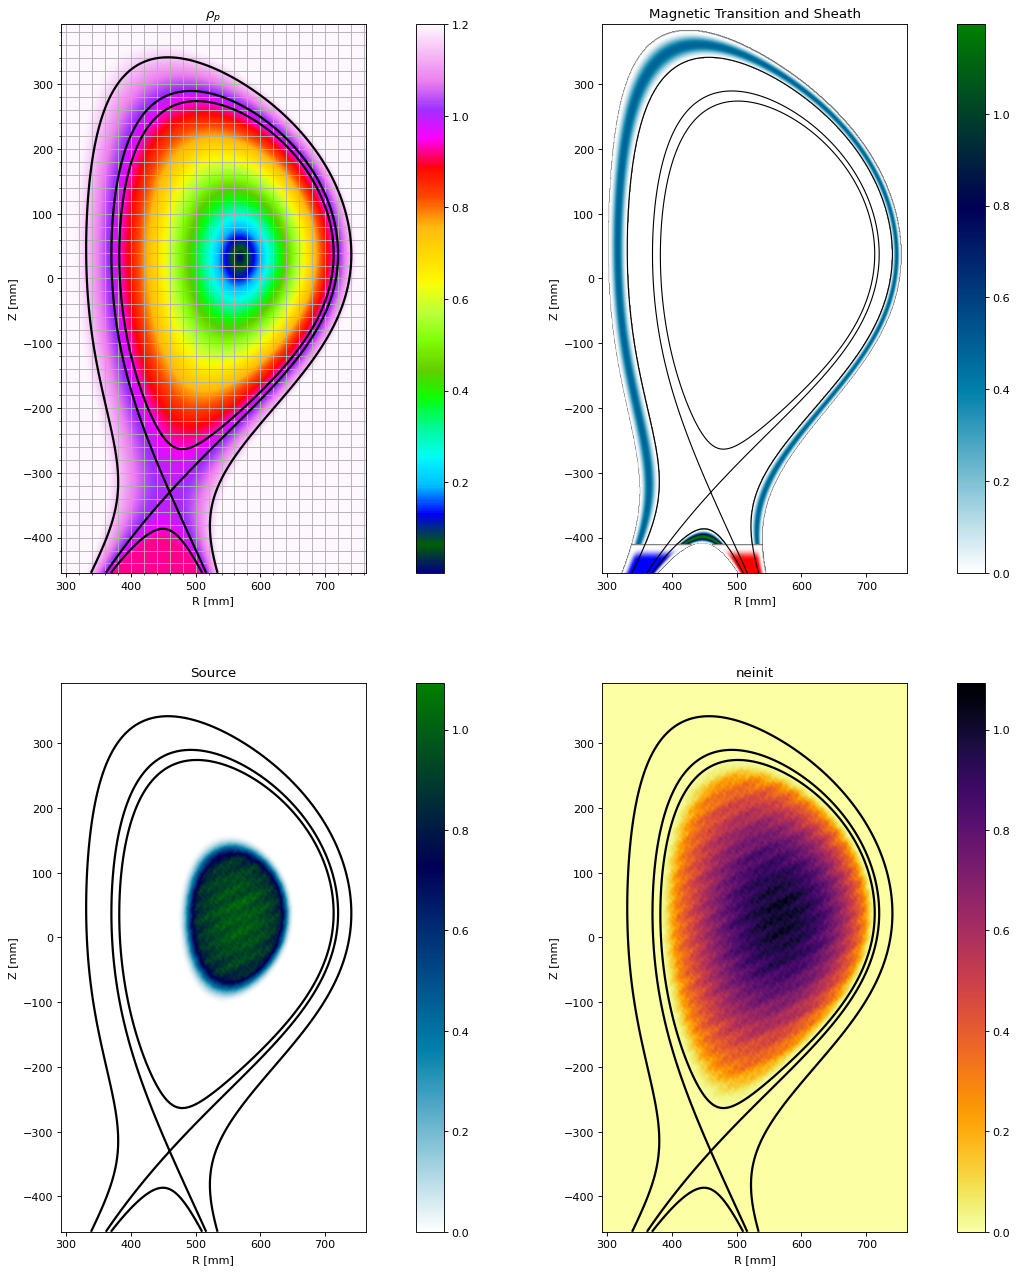

In [5]:
plot("temp.nc")

In [6]:
inputfile = fp.load_calibration_default()
inputfile["magnetic_field"]["params"] = mag.select("COMPASS/compass_2X.json")
rho_s = 1e-3
scaleR = [1.4,1.25]
scaleZ = [2.6,2.6]
inputfile["magnetic_field"]["params"]["R_0"]=inputfile["magnetic_field"]["params"]["R_0"]/rho_s
minor_radius = inputfile["magnetic_field"]["params"]["R_0"]*\
 inputfile["magnetic_field"]["params"]["inverseaspectratio"]
lR = (scaleR[1]+scaleR[0])*minor_radius
lZ = (scaleZ[1]+scaleZ[0])*minor_radius
inputfile["grid"] = {"Nx" : int(lR/2)*2, "Ny" : int(lZ/2)*2, "Nz": 1, "n": 1,
                     "scaleR" : scaleR, "scaleZ" : scaleZ}
inputfile["boundary"]["wall"]["boundary"] = [1.15,0.95]
inputfile["boundary"]["wall"]["alpha"] = [0.10,0.05]
inputfile["boundary"]["sheath"]["boundary"] = 0.25
inputfile["boundary"]["sheath"]["alpha"] = 0.15
#print("grid", json.dumps( inputfile["grid"], indent=4,sort_keys=True))
#print("wall", json.dumps( inputfile["boundary"]["wall"], indent=4,sort_keys=True))
#print("sheath", json.dumps( inputfile["boundary"]["sheath"], indent=4,sort_keys=True))
rep.run( inputfile)

Z:R = 1.9622641509433965
Wall levels =  [0.95, 1, 1.15]
solovev doubleX
triangularity=0.3 elongation=1.4


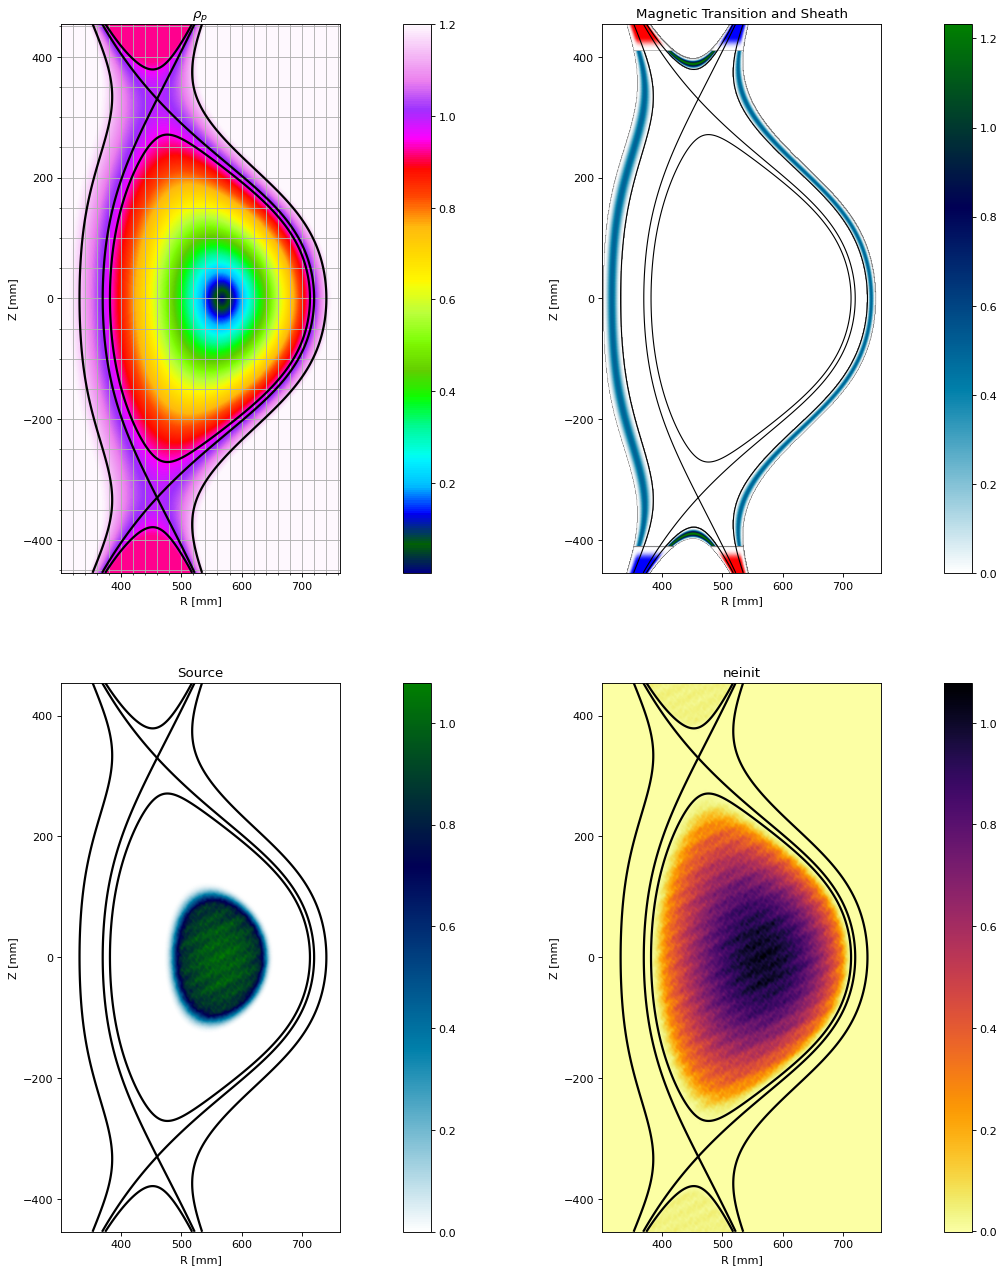

In [7]:
plot("temp.nc")

In [8]:
inputfile = fp.load_calibration_default()
inputfile["magnetic_field"]["params"] = mag.select("COMPASS/compass_-1X.json")
rho_s = 1e-3
scaleR = [1.15,1.26]
scaleZ = [2.1,1.65]
inputfile["magnetic_field"]["params"]["R_0"]=inputfile["magnetic_field"]["params"]["R_0"]/rho_s
minor_radius = inputfile["magnetic_field"]["params"]["R_0"]*\
 inputfile["magnetic_field"]["params"]["inverseaspectratio"]
lR = (scaleR[1]+scaleR[0])*minor_radius
lZ = (scaleZ[1]+scaleZ[0])*minor_radius
inputfile["grid"] = {"Nx" : int(lR/2)*2, "Ny" : int(lZ/2)*2, "Nz": 1, "n": 1,
                     "scaleR" : scaleR, "scaleZ" : scaleZ}
inputfile["boundary"]["wall"]["boundary"] = [1.03,0.97]
inputfile["boundary"]["wall"]["alpha"] = [0.04,0.05]
inputfile["boundary"]["sheath"]["boundary"] = 0.25
inputfile["boundary"]["sheath"]["alpha"] = 0.15
#print("grid", json.dumps( inputfile["grid"], indent=4,sort_keys=True))
#print("wall", json.dumps( inputfile["boundary"]["wall"], indent=4,sort_keys=True))
#print("sheath", json.dumps( inputfile["boundary"]["sheath"], indent=4,sort_keys=True))
rep.run(inputfile)

Z:R = 1.5560165975103732
Wall levels =  [0.97, 1, 1.03]
solovev standardX
triangularity=-0.3 elongation=1.4


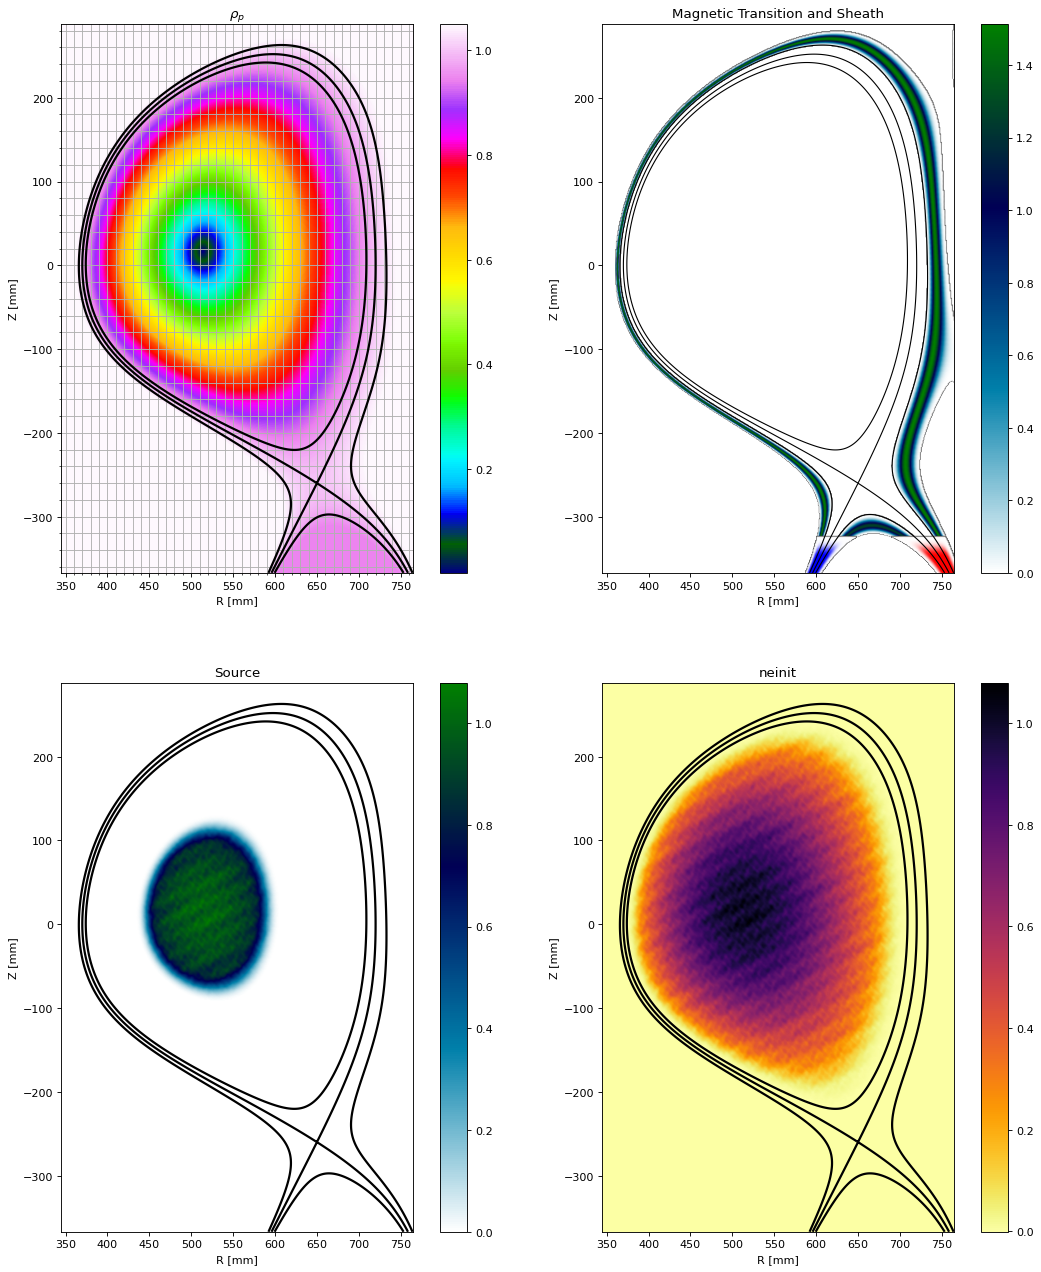

In [9]:
plot("temp.nc")

In [10]:
inputfile = fp.load_calibration_default()
inputfile["magnetic_field"]["params"] = mag.select("COMPASS/compass_-2X.json")
rho_s = 1e-3
scaleR = [1.15,1.25]
scaleZ = [2.1,2.1]
inputfile["magnetic_field"]["params"]["R_0"]=inputfile["magnetic_field"]["params"]["R_0"]/rho_s
minor_radius = inputfile["magnetic_field"]["params"]["R_0"]*\
 inputfile["magnetic_field"]["params"]["inverseaspectratio"]
lR = (scaleR[1]+scaleR[0])*minor_radius
lZ = (scaleZ[1]+scaleZ[0])*minor_radius
inputfile["grid"] = {"Nx" : int(lR/2)*2, "Ny" : int(lZ/2)*2, "Nz": 1, "n": 1,
                     "scaleR" : scaleR, "scaleZ" : scaleZ}
inputfile["boundary"]["wall"]["boundary"] = [1.03,0.95]
inputfile["boundary"]["wall"]["alpha"] = [0.04,0.05]
inputfile["boundary"]["sheath"]["boundary"] = 0.25
inputfile["boundary"]["sheath"]["alpha"] = 0.15
#print("grid", json.dumps( inputfile["grid"], indent=4,sort_keys=True))
#print("wall", json.dumps( inputfile["boundary"]["wall"], indent=4,sort_keys=True))
#print("sheath", json.dumps( inputfile["boundary"]["sheath"], indent=4,sort_keys=True))
rep.run(inputfile)

Z:R = 1.7500000000000002
Wall levels =  [0.95, 1, 1.03]
solovev doubleX
triangularity=-0.3 elongation=1.4


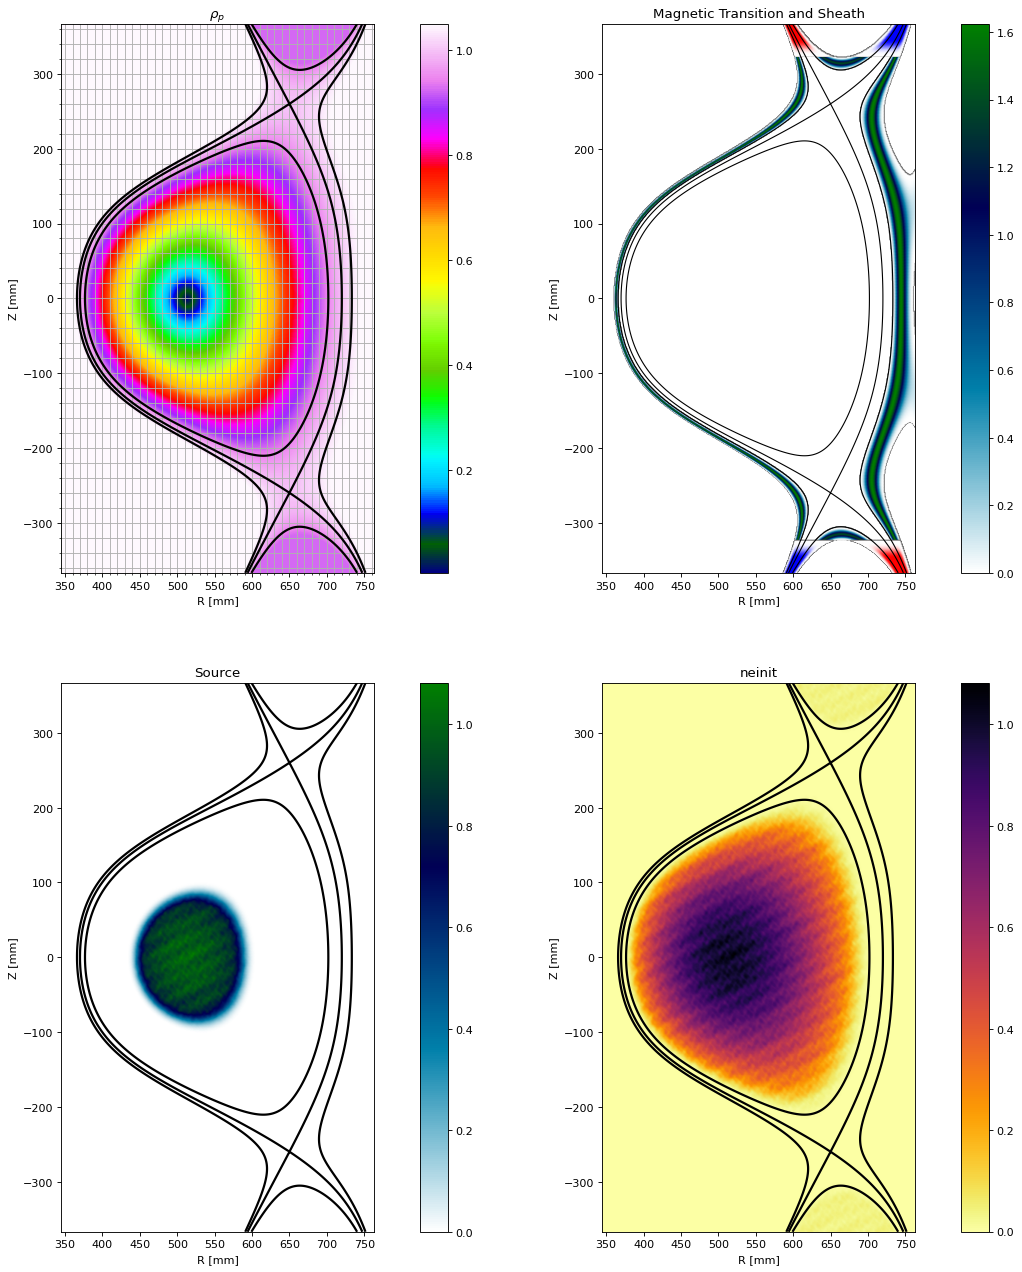

In [11]:
plot("temp.nc")

In [12]:
inputfile = fp.load_calibration_default()
inputfile["magnetic_field"]["params"] = mag.select("enrx_tcv.json")
rho_s = 1e-3
inputfile["magnetic_field"]["params"]["R_0"]=inputfile["magnetic_field"]["params"]["R_0"]/rho_s
scaleR = [1.35,0.95]
scaleZ = [2.5,1.65]
lR = (scaleR[1]+scaleR[0])*minor_radius
lZ = (scaleZ[1]+scaleZ[0])*minor_radius
grid_ratio = lZ/lR
inputfile["grid"] = {"Nx" : int(lR/2)*2, "Ny" : int(lZ/2)*2, "Nz": 1, "n": 1,
                     "scaleR" : scaleR, "scaleZ" : scaleZ}
inputfile["boundary"]["wall"]["boundary"] = [1.09,0.97]
inputfile["boundary"]["wall"]["alpha"] = [0.05,0.05]
inputfile["boundary"]["sheath"]["boundary"] = 0.15
inputfile["boundary"]["sheath"]["alpha"] = 0.05
inputfile["source"]["type"] = "tcv"
#print("grid", json.dumps( inputfile["grid"], indent=4,sort_keys=True))
#print("wall", json.dumps( inputfile["boundary"]["wall"], indent=4,sort_keys=True))
#print("sheath", json.dumps( inputfile["boundary"]["sheath"], indent=4,sort_keys=True))
rep.run(inputfile)

Z:R = 1.8043478260869568
Wall levels =  [0.97, 1, 1.09]
polynomial standardX
triangularity=0.4 elongation=1.5


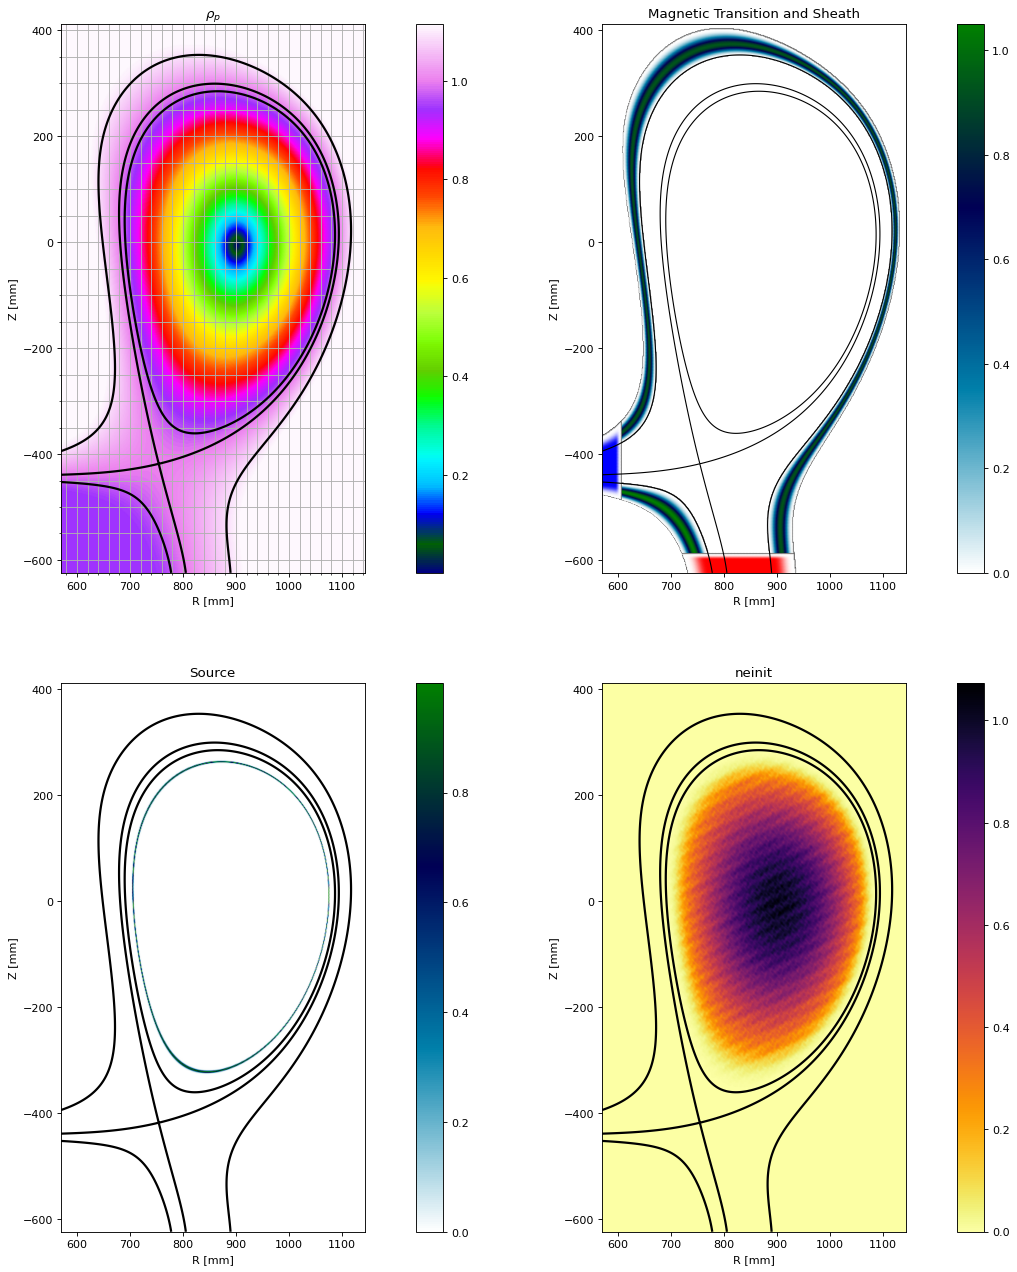

In [13]:
plot("temp.nc")

In [14]:
inputfile = fp.load_calibration_default()
inputfile["magnetic_field"]["params"] = mag.select("enrx_torpex.json")
rho_s = 1e-3
inputfile["magnetic_field"]["params"]["R_0"]=inputfile["magnetic_field"]["params"]["R_0"]/rho_s
inputfile["grid"]["scaleR"] = [1.0,1.0]
inputfile["grid"]["scaleZ"] = [1.0,1.0]
inputfile["boundary"]["wall"]["type"]="none"
inputfile["boundary"]["wall"]["boundary"] = [0.95,1.03]
inputfile["boundary"]["wall"]["alpha"] = [0.05,0.05]
inputfile["boundary"]["wall"]["sign"] = [-1,-1]
inputfile["boundary"]["sheath"]["type"]="none"
inputfile["boundary"]["sheath"]["boundary"] = 0.15
inputfile["boundary"]["sheath"]["alpha"] = 0.05
inputfile["init"]["profile"]["type"] = "zero"
inputfile["init"]["damping"]["type"] = "none"
inputfile["source"]["damping"]["type"] = "none"
inputfile["source"]["type"] = "torpex"
# print( json.dumps( inputfile["source"], indent=4,sort_keys=True))
# print("wall", json.dumps( inputfile["boundary"]["wall"], indent=4,sort_keys=True))
#print("sheath", json.dumps( inputfile["boundary"]["sheath"], indent=4,sort_keys=True))
rep.run(inputfile)

Z:R = 1.0
Wall levels =  [0.95, 1, 1.03]
solovev centeredX
triangularity=0.0 elongation=1.0


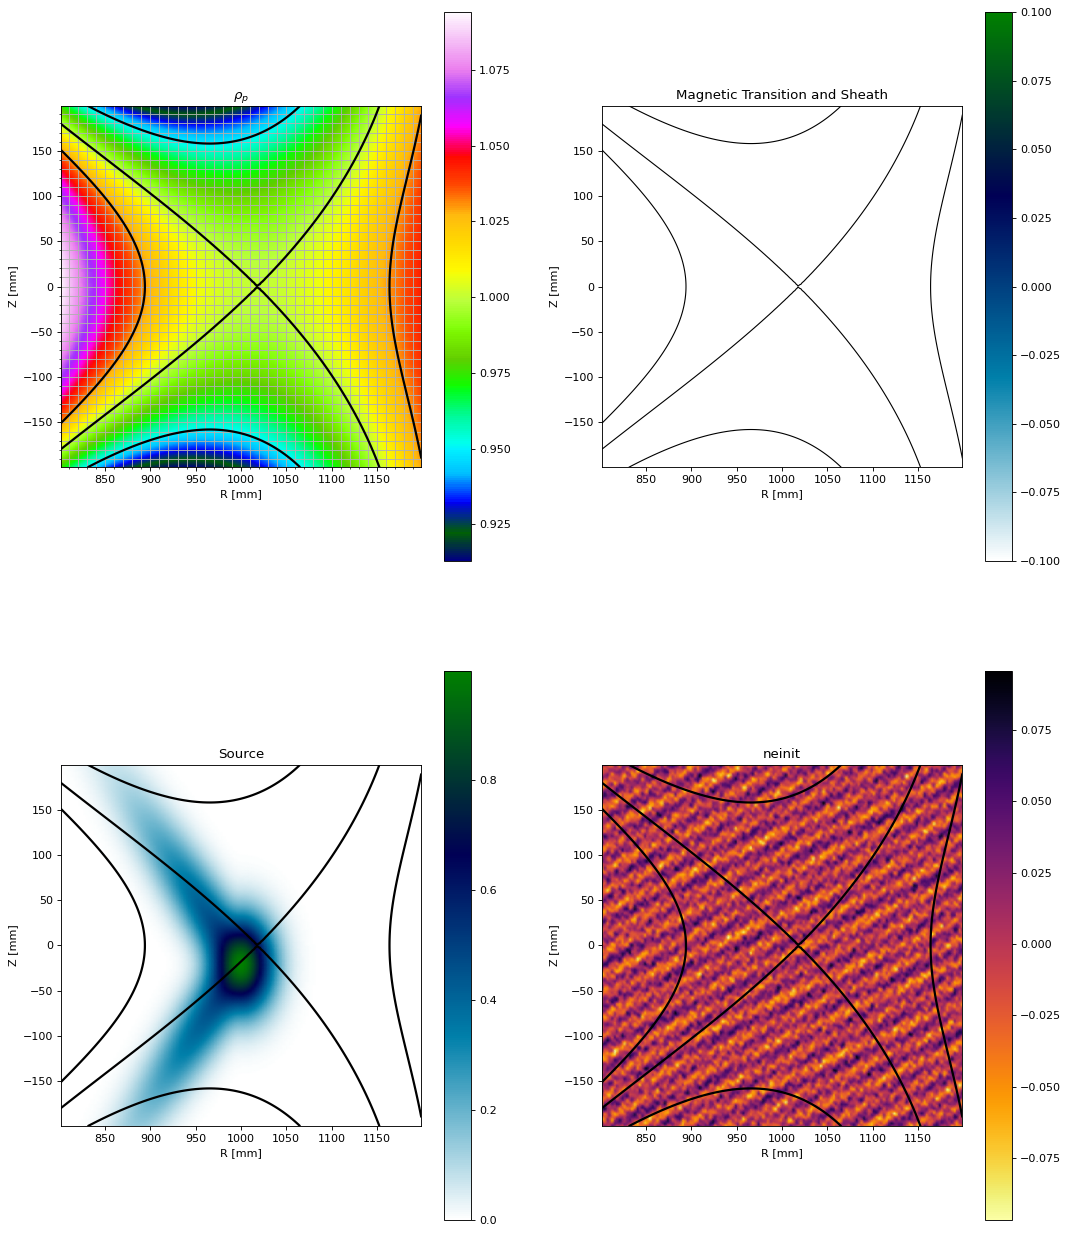

In [15]:
plot("temp.nc")

If wall or sheath are desired then we either need to implement transformation or work with and find the psi values where to dampen

In [16]:
# clean up
rep.clean()